In [1]:
# Run in python console
import nltk; nltk.download('stopwords')
import spacy

import re
import os
import numpy as np
import pandas as pd

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
import en_core_web_sm

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from langdetect import detect

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

from yellowbrick.features import FeatureImportances

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielacollaguazo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [143]:
# import sys
# !{sys.executable} -m pip install seaborn
# # !{sys.executable} -m spacy download en_core_web_sm

# Understanding how listing description influence price and listing rating

The AirBnb dataset provides with features not only that have numeric or structured values but also unstructured data. To mention a few examples: the name of of the property, a short description of the space, an overview of the neighborhood and a description of the listing itself. As part of our project we would like to use Natural Language Processing techniques to understand how unstructured data available for each listing might influence price.

The reason we believe that there might be a relationship betweeen the listing description and the price is because 
we think that what makes a listing valuable is not only their features per se but also the way the place is presented to the potential guest. This, not only includes the pictures of the listing but also the words that the listing owners pick to describe their listing and assumingly seeks to attrack their potential customers. We assume that by including certain words in the description could potentially increase the attractiveness of a certain property to be rented. T
the value of the listing in the AirBnb market. Thus, due to supply and demand law, we could potentially assume that the more demanded a property is, the higher the value it could have. 

To begin with the analysis we want to see if there are similarities in the way listing owners describe their place and the price they charge per night. We proceed with the assumption that listings with similar features will use similar words to describe their property. Furthermore we are curious about how words in the description could inform us about the listing's overall rating.

For this reason we will be using this notebook to try to answer the following questions:

1. Do listings using similar words in their description share a similar price?
2. Do listings using similar words in their description share other features that are relevant to predict price?
3. Do listings using similar words in their description end up having similar guest acceptance/rating?

For this purpose we will first, use Latent Dirichlet Allocation to elicit the latent topics in the description. Latent Dirichlet Allocation is an unsupervised algorithm, largely used in Natural Language Processing to perform what is known as Topic Modeling. This algorightm uses probability distribution to discover which parts of the data are similar. In the context of our project we would try to discover the similar words used the description of New York City listings that could potentially influence price.

## Importing data into DataFrame

In [144]:
path = '../data/new-york-city-airbnb-open-data/'
listings_csv = os.path.join(path,'listings.csv')

listings_df =  pd.read_csv(listings_csv,low_memory=False)

In [145]:
# Creating content column with name and description of property
listings_df['content'] = listings_df['name'] + listings_df['description']
content = listings_df[['id','content']]

In [146]:
# Importing model df
model_cols_df = pd.read_csv('../data/new-york-city-airbnb-open-data/model_columns_listings.csv',index_col = 0)

In [147]:
model_cols_df.iloc[:,0:4].head()

,id,host_since,host_is_superhost,host_identity_verified
0,2595,733294,0,1
1,3831,733383,0,1
2,5099,733440,0,0
3,5121,733441,0,0
4,5178,733469,0,0


In [148]:
# Joining the new created 'content' column with the model dataframe just to choose rows that are relevant
df_model = pd.merge(left=model_cols_df, right=content, how='left', on='id')

# dropping null values
df_model = df_model.dropna()

In [149]:
df_model.iloc[:,0:4].head()

,id,host_since,host_is_superhost,host_identity_verified
0,2595,733294,0,1
1,3831,733383,0,1
2,5099,733440,0,0
3,5121,733441,0,0
4,5178,733469,0,0


## Predicting Language from content

As we may already know, AirBnb is a platform used by people from all around the world. Therefore, some hosts that want to attract guests who speak languages other than English might want to use different language or languages to describe their place. For our analysis we want to make sure that we are working with a single language and since the majority of reviews are written in English, we will use langdetect, to determine those descriptions written in English only. Langdetect is a language detection algorithm that supports 55 languages out of the box. To maximize the probability of the algorithms predicting the correct language we make sure we send it a long enough string.

In [150]:
def predict_lang(x):
    lang=''
    txt_len=len(x)
    if txt_len>50:
        try:
            lang=detect(x)
        except Exception as e:
            lang=''
    return lang

In [151]:
df_model['content_lang'] = df_model.content.apply(lambda x: predict_lang(x))

In [152]:
# getting only text in English
df_model_en_desc = df_model[df_model.content_lang=='en']

In [153]:
df_model.shape, df_model_en_desc.shape

((27354, 47), (27107, 47))

In [154]:
df_model_en_desc.iloc[:,0:4].head()

,id,host_since,host_is_superhost,host_identity_verified
0,2595,733294,0,1
1,3831,733383,0,1
2,5099,733440,0,0
3,5121,733441,0,0
4,5178,733469,0,0


## LDA for Topic Modeling in Listing Description

In [155]:
def generate_list_content(df):
#     df['content'] = df['name'] + df['summary']
#     df['content'] = df['content'].replace(np.nan, '', regex=True)
    
    # Convert to list
    data = df['content'].values.tolist()

    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]
    
    
    return data

In [156]:
lst_texts = generate_list_content(df_model_en_desc)

In [157]:
len(lst_texts)

27107

## Tokenize words and clean up text

In [158]:
# here we are tokenizing each document.
def content_to_words(lst_texts):
    for text in lst_texts:
        yield(gensim.utils.simple_preprocess(str(text), deacc=True))
        
# data_words is a list where each element is the tokenized document
tokenized_content = list(content_to_words(lst_texts))

## Create bigram and trigrams

In [159]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_content, min_count=10, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokenized_content], threshold=100)  


# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

## Remove Stopwords, Make Bigrams and Lemmatize

In [160]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(tokenized_content):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in tokenized_content]

def make_bigrams(tokenized_content):
    return [bigram_mod[doc] for doc in tokenized_content]

def make_trigrams(tokenized_content):
    return [trigram_mod[bigram_mod[doc]] for doc in tokenized_content]

def lemmatization(tokenized_content, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in tokenized_content:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

In [161]:
# Remove Stop Words
tokenized_content_nostops = remove_stopwords(tokenized_content)

# Form Bigrams
tokenized_content_bigrams = make_bigrams(tokenized_content_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
tokenized_content_lemmatized = lemmatization(tokenized_content_bigrams, 
                                             allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

## Create the Dictionary and Corpus needed for Topic Modeling

In [162]:
# Create Dictionary:
# Mapping from word IDs to words. 
# It is used to determine the vocabulary size, as well as for debugging and topic printing.
id2word = corpora.Dictionary(tokenized_content_lemmatized)
# print(len(id2word)) # corpus has 14118 unique tokens

# Term Document Frequency
# Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples.
# Word with their corresponding id
corpus = [id2word.doc2bow(text) for text in tokenized_content_lemmatized]

# View
# print(corpus[:1])

The biggest challenge of using LDA for Topic Modeling is determining the right amount of topics *n*. Therefore we will use two metrics: Perplexity and Coherence as well as the pyLDAvis to approximately determine the right number of topics that are latent in our corpus (description).

## Build list of topic models

In [163]:
def build_topics(num_topics):
    list_models=[]
    for n in num_topics:
        topic_name = 'lda_model_' + str(n)
        topic_name = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, 
                                                     num_topics=n, random_state=100, 
                                                     update_every=1, chunksize=100, 
                                                     passes=10, alpha='auto', 
                                                     per_word_topics=True)
        list_models.append(topic_name)
    return list_models

num_topics = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
# num_topics = [2,3,4,5]
models = build_topics(num_topics)

## Compute Model Perplexity and Coherence Score for all models

In [ ]:
The literature says that Coherence is 

In [164]:
def calc_perplexity_coherence(models):
    list_perplexity = []
    list_coherence = []
    
    for model in models:
        list_perplexity.append(model.log_perplexity(corpus))
        coherence_model_lda = CoherenceModel(model=model, texts=tokenized_content_lemmatized, 
                                             dictionary=id2word, coherence='c_v')
        list_coherence.append(coherence_model_lda.get_coherence())
    return list_perplexity, list_coherence

x = calc_perplexity_coherence(models)      

In [166]:
df_metrics = pd.DataFrame(list(x)).transpose()
df_metrics.columns = ['Perplexity','Coherence']
df_metrics['Number of topics'] = num_topics
df_metrics

,Perplexity,Coherence,Number of topics
0,-6.693067,0.461696,2
1,-6.679960,0.476584,3
2,-6.687329,0.486303,4
3,-6.701834,0.487602,5
4,-6.718280,0.477567,6
5,-6.743821,0.523782,7
6,-6.780489,0.537412,8
7,-6.834924,0.475515,9
8,-6.928041,0.447606,10
9,-7.092811,0.444098,11


## Graphic of number of Topics and Perplexity

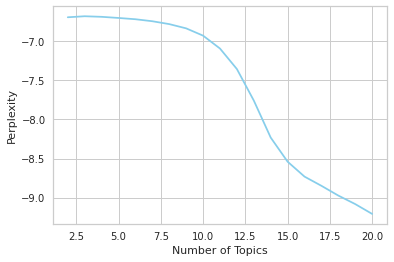

In [167]:
# Perplexity needs to be as low as possible 
plt.plot( 'Number of topics', 'Perplexity', data=df_metrics, color='skyblue')
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.show()

## Graphic of number of Topics and Coherence

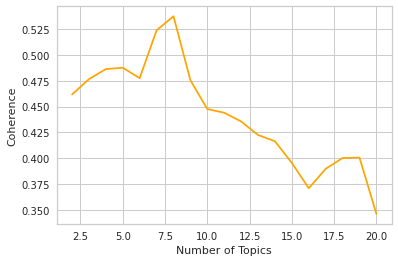

In [168]:
# Perplexity needs to be as low as possible 
plt.plot( 'Number of topics', 'Coherence', data=df_metrics, color='orange')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence")
plt.show()

## Visualizing topics accordint to the best *n*

### Five topics

In [198]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(models[3], corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      24.677443        1       1  0.118268 -0.097330
3      24.673487        1       2 -0.109437  0.249829
0      23.814632        1       3 -0.266629  0.043374
2      20.326958        1       4 -0.100212 -0.263063
4       6.507476        1       5  0.358009  0.067189, topic_info=     Category          Freq          Term         Total  loglift  logprob
term                                                                     
102   Default  40014.000000          room  40014.000000  30.0000  30.0000
145   Default  21825.000000          walk  21825.000000  29.0000  29.0000
113   Default  43632.000000     apartment  43632.000000  28.0000  28.0000
109   Default  17627.000000         train  17627.000000  27.0000  27.0000
8     Default  16631.000000           bed  16631.000000  26.0000  26.0000
96    Default  16711.000000        minute  16711.000000  25.0000  25.0000
99    Default  20043.000000       private  20043.000000  24.0000  24.0000
200   Default  15294.000000          away  15294.000000  23.0000  23.0000
221   Default  16418.000000    restaurant  16418.000000  22.0000  22.0000
202   Default  15149.000000      bathroom  15149.000000  21.0000  21.0000
293   Default  12510.000000          stay  12510.000000  20.0000  20.0000
25    Default   6342.000000         heart   6342.000000  19.0000  19.0000
66    Default  28254.000000       bedroom  28254.000000  18.0000  18.0000
21    Default  11683.000000         floor  11683.000000  17.0000  17.0000
67    Default  11420.000000         block  11420.000000  16.0000  16.0000
234   Default   9386.000000           bar   9386.000000  15.0000  15.0000
22    Default  12644.000000          full  12644.000000  14.0000  14.0000
56    Default   4926.000000        studio   4926.000000  13.0000  13.0000
341   Default   8812.000000          good   8812.000000  12.0000  12.0000
205   Default   9192.000000         close   9192.000000  11.0000  11.0000
90    Default  16966.000000         guest  16966.000000  10.0000  10.0000
29    Default  10112.000000       kitchen  10112.000000   9.0000   9.0000
257   Default  11705.000000  neighborhood  11705.000000   8.0000   8.0000
142   Default   7974.000000        subway   7974.000000   7.0000   7.0000
131   Default   9635.000000        living   9635.000000   6.0000   6.0000
556   Default   7926.000000           new   7926.000000   5.0000   5.0000
241   Default   7460.000000      distance   7460.000000   4.0000   4.0000
141   Default   7263.000000       station   7263.000000   3.0000   3.0000
312   Default  11338.000000          home  11338.000000   2.0000   2.0000
62    Default   6990.000000            tv   6990.000000   1.0000   1.0000
...       ...           ...           ...           ...      ...      ...
573    Topic5    536.590027      boutique    537.464966   2.7306  -5.3554
336    Topic5    522.764465       culture    523.646484   2.7305  -5.3815
1261   Topic5    525.989380         spend    526.882812   2.7305  -5.3753
1429   Topic5    486.796631         prime    487.676636   2.7304  -5.4528
305    Topic5    458.637512      district    459.525940   2.7303  -5.5124
1799   Topic5    404.357483     chinatown    405.234680   2.7301  -5.6383
1107   Topic5    409.197723        action    410.096497   2.7300  -5.6264
2132   Topic5    397.903015          hell    398.784119   2.7300  -5.6544
1089   Topic5    393.958954       chelsea    394.832245   2.7300  -5.6644
400    Topic5    382.141815      fabulous    383.035858   2.7299  -5.6948
1143   Topic5    348.614471       bedford    349.490723   2.7297  -5.7867
25     Topic5   6326.229980         heart   6342.434570   2.7297  -2.8882
981    Topic5    348.040405       nestled    348.956421   2.7296  -5.7883
2188   Topic5    309.265869        iconic    310.140778   2.7294  -5.9064
239    Topic5   1868.871826          cool   2195.809570   2.5710  -4.1075
0      Topic5   2520.864502

In [197]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(models[5], corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      25.264040        1       1  0.152505  0.010955
1      22.631130        1       2  0.105786 -0.299303
3      20.947756        1       3  0.104741 -0.135322
6      15.351338        1       4  0.147203  0.140570
0       8.553752        1       5 -0.013780  0.285488
5       4.689999        1       6 -0.088969  0.082989
4       2.561989        1       7 -0.407486 -0.085377, topic_info=     Category          Freq        Term         Total  loglift  logprob
term                                                                   
102   Default  39008.000000        room  39008.000000  30.0000  30.0000
66    Default  28819.000000     bedroom  28819.000000  29.0000  29.0000
145   Default  21932.000000        walk  21932.000000  28.0000  28.0000
90    Default  16504.000000       guest  16504.000000  27.0000  27.0000
109   Default  17714.000000       train  17714.000000  26.0000  26.0000
113   Default  43353.000000   apartment  43353.000000  25.0000  25.0000
99    Default  19716.000000     private  19716.000000  24.0000  24.0000
96    Default  16793.000000      minute  16793.000000  23.0000  23.0000
221   Default  16397.000000  restaurant  16397.000000  22.0000  22.0000
8     Default  17069.000000         bed  17069.000000  21.0000  21.0000
200   Default  15369.000000        away  15369.000000  20.0000  20.0000
293   Default  12797.000000        stay  12797.000000  19.0000  19.0000
556   Default   8132.000000         new   8132.000000  18.0000  18.0000
21    Default  11671.000000       floor  11671.000000  17.0000  17.0000
183   Default   9975.000000       share   9975.000000  16.0000  16.0000
22    Default  12934.000000        full  12934.000000  15.0000  15.0000
67    Default  11476.000000       block  11476.000000  14.0000  14.0000
385   Default   5453.000000     provide   5453.000000  13.0000  13.0000
121   Default   6994.000000      coffee   6994.000000  12.0000  12.0000
370   Default   8840.000000       clean   8840.000000  11.0000  11.0000
176   Default   9726.000000       place   9726.000000  10.0000  10.0000
45    Default   6098.000000    renovate   6098.000000   9.0000   9.0000
312   Default  11537.000000        home  11537.000000   8.0000   8.0000
6     Default  12379.000000   available  12379.000000   7.0000   7.0000
205   Default   9237.000000       close   9237.000000   6.0000   6.0000
38    Default   6029.000000      modern   6029.000000   5.0000   5.0000
234   Default   9266.000000         bar   9266.000000   4.0000   4.0000
131   Default   9839.000000      living   9839.000000   3.0000   3.0000
186   Default  16002.000000       space  16002.000000   2.0000   2.0000
60    Default   4055.000000       towel   4055.000000   1.0000   1.0000
...       ...           ...         ...           ...      ...      ...
1485   Topic7    873.679016   nightlife    874.601990   3.6633  -3.9357
647    Topic7    864.847290      artist    865.768311   3.6633  -3.9459
1111   Topic7    811.981873  laundromat    812.906433   3.6632  -4.0090
927    Topic7    801.730347        soho    802.651978   3.6632  -4.0217
752    Topic7    747.771790        loft    748.696960   3.6632  -4.0914
577    Topic7    567.113037    designer    568.034729   3.6628  -4.3679
573    Topic7    554.491699    boutique    555.413147   3.6627  -4.3904
816    Topic7    482.836395       oasis    483.759094   3.6625  -4.5288
305    Topic7    473.973785    district    474.897430   3.6624  -4.5473
868    Topic7    445.508575     vintage    446.429901   3.6623  -4.6092
1107   Topic7    422.786346      action    423.713470   3.6622  -4.6616
1799   Topic7    417.866486   chinatown    418.787964   3.6622  -4.6733
1089   Topic7    407.077972     chelsea    407.999390   3.6621  -4.6994
17     Topic7    402.600555    eclectic    403.523254   3.6621  -4.7105
981    Topic7    359.766663     nestled    360.693268   3.6618  -4.8230
2188   Topic7  

## Creating DataFrame with scores and topics for 5 topics

In [170]:
# function that returns data frame with 
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=lst_texts):
    # Init output
    sent_topics_df = list()
#     df_model_en_desc.reset_index(inplace=True)
    
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
#         print(row)
        sent_topics_df.append(row)
        
    sent_topics_df = pd.DataFrame(sent_topics_df)
    sent_topics_df.columns = ['Dominant_Topic_1', 'Dominant_Topic_2', 'Dominant_Topic_3','Dominant_Topic_4','Dominant_Topic_5']
    sent_topics_df = pd.concat([df_model_en_desc['id'],sent_topics_df], axis=1)
    df_n_cols = sent_topics_df.shape[1]
    
    return sent_topics_df, df_n_cols

In [171]:
sent_topics_df, df_n_cols = format_topics_sentences(ldamodel=models[3], corpus=corpus, texts=lst_texts)

In [172]:
sent_topics_df.head()

,id,Dominant_Topic_1,Dominant_Topic_2,Dominant_Topic_3,Dominant_Topic_4,Dominant_Topic_5
0,2595.0,"(2, 0.40948057)","(0, 0.32991496)","(4, 0.15354563)","(1, 0.06725317)","(3, 0.039805666)"
1,3831.0,"(2, 0.5316776)","(0, 0.21664086)","(1, 0.13210663)","(3, 0.11034215)",None
2,5099.0,"(2, 0.38393718)","(0, 0.26523867)","(1, 0.2431207)","(3, 0.0719119)","(4, 0.035791583)"
3,5121.0,"(3, 0.7086276)","(0, 0.114929706)","(1, 0.07816244)","(4, 0.05632117)","(2, 0.04195903)"
4,5178.0,"(0, 0.4539366)","(3, 0.2406738)","(1, 0.19286269)","(2, 0.10396423)",None


In [173]:
sent_topics_df.shape

(27857, 6)

In [174]:
sent_topics_df = sent_topics_df.dropna()

In [175]:
sent_topics_df.shape

(24767, 6)

### Separating the Topic from its score

In [176]:
for i in range(1,df_n_cols):
    top_col = 'topic' + str(i)
    score_col = 'score_dom_topic_' + str(i)
    sent_topics_df[top_col] = pd.DataFrame(sent_topics_df.iloc[:,i].tolist(), index=sent_topics_df.index)[0]
    sent_topics_df[score_col] = pd.DataFrame(sent_topics_df.iloc[:,i].tolist(), index=sent_topics_df.index)[1]

In [177]:
sent_topics_df.head()

,id,Dominant_Topic_1,Dominant_Topic_2,Dominant_Topic_3,Dominant_Topic_4,Dominant_Topic_5,topic1,score_dom_topic_1,topic2,score_dom_topic_2,topic3,score_dom_topic_3,topic4,score_dom_topic_4,topic5,score_dom_topic_5
0,2595.0,"(2, 0.40948057)","(0, 0.32991496)","(4, 0.15354563)","(1, 0.06725317)","(3, 0.039805666)",2,0.409481,0,0.329915,4,0.153546,1,0.067253,3,0.039806
2,5099.0,"(2, 0.38393718)","(0, 0.26523867)","(1, 0.2431207)","(3, 0.0719119)","(4, 0.035791583)",2,0.383937,0,0.265239,1,0.243121,3,0.071912,4,0.035792
3,5121.0,"(3, 0.7086276)","(0, 0.114929706)","(1, 0.07816244)","(4, 0.05632117)","(2, 0.04195903)",3,0.708628,0,0.114930,1,0.078162,4,0.056321,2,0.041959
5,5238.0,"(4, 0.2658736)","(3, 0.24069966)","(1, 0.23546997)","(2, 0.14184159)","(0, 0.11611518)",4,0.265874,3,0.240700,1,0.235470,2,0.141842,0,0.116115
6,5441.0,"(3, 0.30731502)","(0, 0.26041567)","(1, 0.21975623)","(2, 0.13083145)","(4, 0.0816816)",3,0.307315,0,0.260416,1,0.219756,2,0.130831,4,0.081682


In [178]:
# Dropping columns with tuples
cols_2_drop = ['Dominant_Topic_1', 'Dominant_Topic_2','Dominant_Topic_3','Dominant_Topic_4','Dominant_Topic_5']
sent_topics_df.drop(columns=cols_2_drop, inplace=True)

In [179]:
sent_topics_df.head()

,id,topic1,score_dom_topic_1,topic2,score_dom_topic_2,topic3,score_dom_topic_3,topic4,score_dom_topic_4,topic5,score_dom_topic_5
0,2595.0,2,0.409481,0,0.329915,4,0.153546,1,0.067253,3,0.039806
2,5099.0,2,0.383937,0,0.265239,1,0.243121,3,0.071912,4,0.035792
3,5121.0,3,0.708628,0,0.114930,1,0.078162,4,0.056321,2,0.041959
5,5238.0,4,0.265874,3,0.240700,1,0.235470,2,0.141842,0,0.116115
6,5441.0,3,0.307315,0,0.260416,1,0.219756,2,0.130831,4,0.081682


In [180]:
# Formatting DataFrame
sent_topics_df.rename(columns={"topic1": "winner_topic",
                               "score_dom_topic_1":"winner_topic_score",
                               "topic2": "second_place_topic",
                               "score_dom_topic_2":"second_topic_score",
                               "topic3": "third_place_topic",
                               "score_dom_topic_3":"third_topic_score",
                               "topic4": "fourth_place_topic",
                               "score_dom_topic_4":"fourth_topic_score",
                              "topic5": "fifth_place_topic",
                               "score_dom_topic_5":"fifth_topic_score"},inplace=True)

In [181]:
sent_topics_df.head()

,id,winner_topic,winner_topic_score,second_place_topic,second_topic_score,third_place_topic,third_topic_score,fourth_place_topic,fourth_topic_score,fifth_place_topic,fifth_topic_score
0,2595.0,2,0.409481,0,0.329915,4,0.153546,1,0.067253,3,0.039806
2,5099.0,2,0.383937,0,0.265239,1,0.243121,3,0.071912,4,0.035792
3,5121.0,3,0.708628,0,0.114930,1,0.078162,4,0.056321,2,0.041959
5,5238.0,4,0.265874,3,0.240700,1,0.235470,2,0.141842,0,0.116115
6,5441.0,3,0.307315,0,0.260416,1,0.219756,2,0.130831,4,0.081682


### Understanding the topic that appears as winner the most

winner_topic
0.0     1827
1.0     6567
2.0     1555
3.0     2103
4.0    14307
Name: winner_topic, dtype: int64


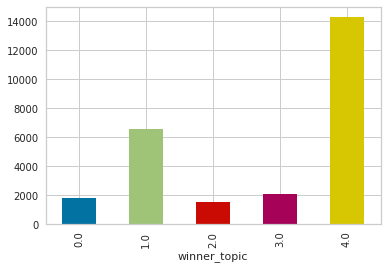

In [182]:
df = df_model_en_desc_merged.groupby('winner_topic')['winner_topic'].size()
print(df)
df.plot(kind='bar')

## Modeling

In [183]:
# Merging the initial DataFrame with features with the topics DataFrame
df_model_en_desc_merged = pd.merge(left=df_model_en_desc, right=sent_topics_df, how='left', on='id')

In [184]:
df_model_en_desc_merged.iloc[:,0:6].head()

,id,host_since,host_is_superhost,host_identity_verified,is_location_exact,accommodates
0,2595,733294,0,1,0,2
1,3831,733383,0,1,1,3
2,5099,733440,0,0,0,2
3,5121,733441,0,0,0,2
4,5178,733469,0,0,1,2


In [185]:
df_model_en_desc_merged.shape

(27107, 57)

In [186]:
df_model_en_desc_merged = df_model_en_desc_merged.dropna()

In [187]:
df_model_en_desc_merged.shape

(24767, 57)

### Creating features X

In [188]:
X = df_model_en_desc_merged.iloc[:, 1:]
X = X.loc[:, X.columns != 'price']
X = X.loc[:, X.columns != 'content']
X = X.loc[:, X.columns != 'content_lang']

### Creating target y

In [189]:
y = df_model_en_desc_merged.price

## Split train - test sets

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [191]:
# Creating a list of features to use as labels in FeatureImportances
features=list()

for col in df_model_en_desc_merged.columns:
    features.append(col)

# Removing price and id from labels
features.remove('price')
features.remove('content')
features.remove('content_lang')
features.remove('id')

In [192]:
X_train.shape, len(features), y_train.shape

((19813, 53), 53, (19813,))

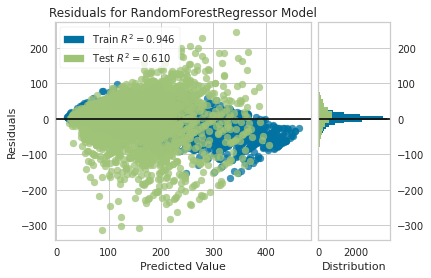

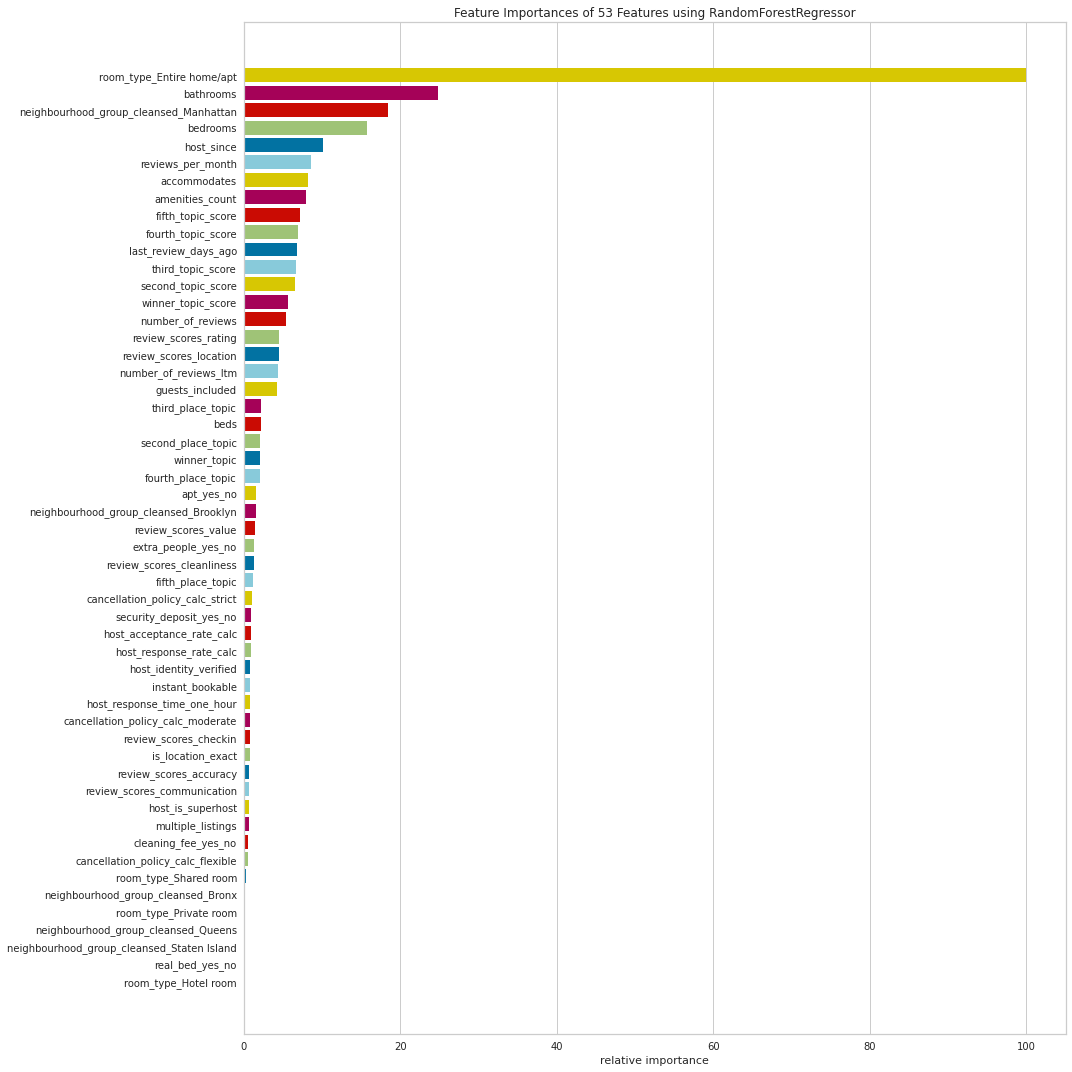

In [193]:
regressors = {
#     "support vector machine": SVR(),
#     "multilayer perceptron": MLPRegressor(),
#     "nearest neighbors": KNeighborsRegressor(),
#     "bayesian ridge": BayesianRidge(),
#     "linear regression": LinearRegression(),
    "random forest": RandomForestRegressor(),
}

for _, regressor in regressors.items():
    visualizer = ResidualsPlot(regressor)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()
    
    viz = FeatureImportances(regressor, labels=features, size=(1080, 1080))

    viz.fit(X_train, y_train)
    # Note: the FeatureImportances visualizer is a model visualizer,
    # not a feature visualizer, so it doesn't have a transform method!
    viz.show()

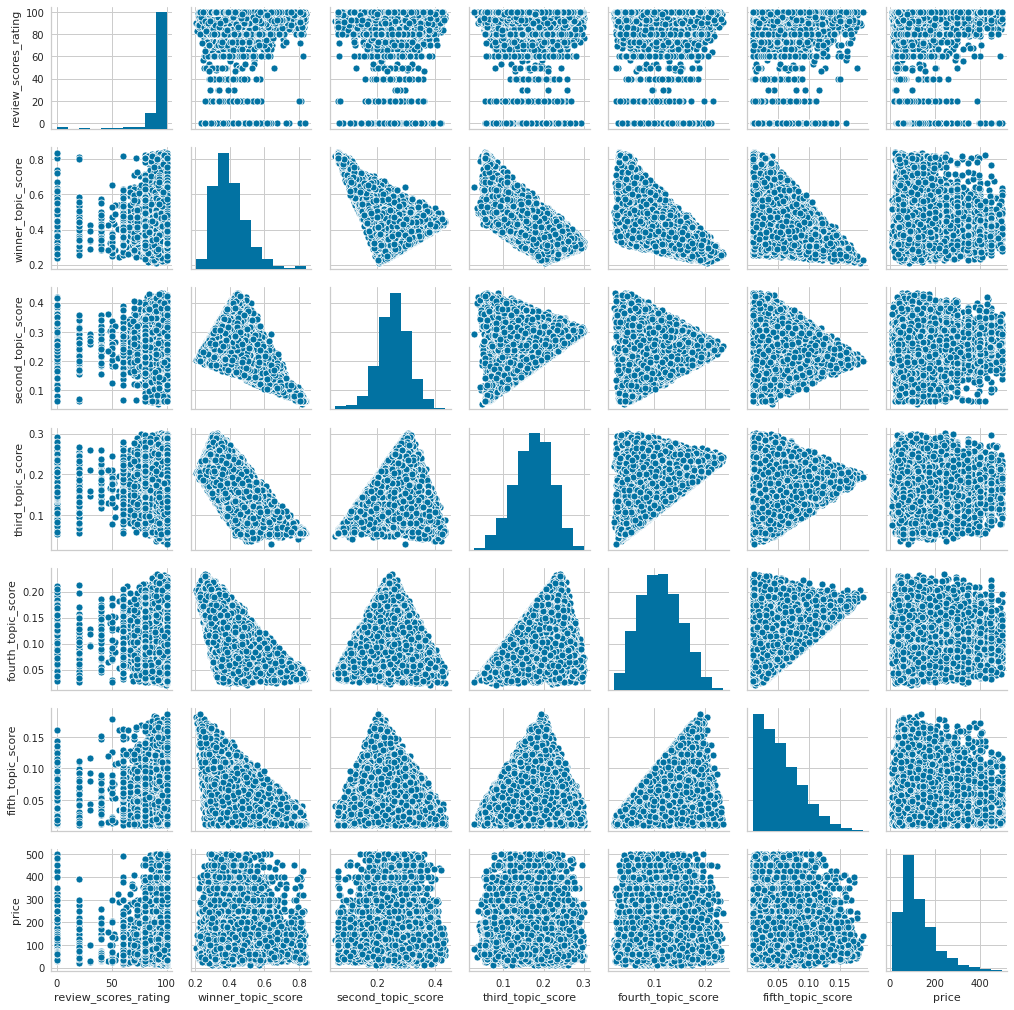

In [194]:
df_price_rat_scores = df_model_en_desc_merged.loc[:,['review_scores_rating','winner_topic_score',
                                                     'second_topic_score', 'third_topic_score',
                                                     'fourth_topic_score','fifth_topic_score','price']]

sns.pairplot(df_price_rat_scores,height=2)

H1: No relationship was discovered with any of the topic scores and price or most salient review score rating

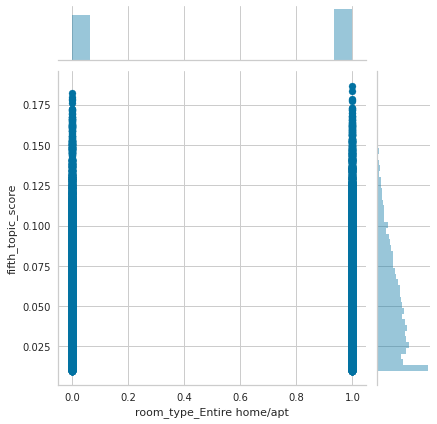

In [195]:
sns.jointplot(x='room_type_Entire home/apt', y='fifth_topic_score', data=df_model_en_desc_merged);

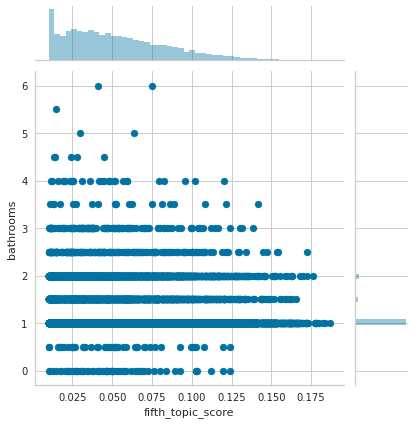

In [196]:
sns.jointplot(x='fifth_topic_score', y='bathrooms', data=df_model_en_desc_merged);